# Initial Setup

In [1]:
%pip install spark-nlp

Note: you may need to restart the kernel to use updated packages.


In [1]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = (
    SparkSession.builder.appName("DataIntegration")
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.5.2")
    .config("spark.executor.memory", "10g")
    .config("spark.driver.memory", "10g")
    .getOrCreate()
)

In [2]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, FloatType
import pyspark.sql.functions as F
import json

# Open the JSON file
with open('data/company_data.json', 'r') as file:
    # Load the contents of the file into a dictionary
    data = json.load(file)


def convert_to_numeric(value):
    try:
        if '.' in value:
            return float(value)
        else:
            return int(value)
    except (ValueError, TypeError):
        return value

def convert_nested_fields(data):
    if isinstance(data, dict):
        return {k: convert_nested_fields(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [convert_nested_fields(item) for item in data]
    else:
        return convert_to_numeric(data)

def strip_wellfound_id(data):
    for key, value in data.items():
        if key == 'id':
            data[key] = value.split('\\')[-1]
    return data


array_data = list(data.values())
array_data = convert_nested_fields(array_data)
array_data = [strip_wellfound_id(data) for data in array_data]

# Define the schema for the JSON file
schema = StructType([
    StructField("id", StringType(), False),
    StructField("name", StringType(), False),
    StructField("slogan", StringType(), True),
    StructField("description", StringType(), True),
    StructField("locations", ArrayType(StringType()), True),
    StructField("size", StringType(), True),
    StructField("total_funding", FloatType(), True),
    StructField("type", ArrayType(StringType()), True),
    StructField("industries", ArrayType(StringType()), True),
    StructField("valuation", FloatType(), True),
    StructField("num_of_funding_rounds", IntegerType(), True),
    StructField("funding_rounds", ArrayType(
        StructType([
            StructField("amount", FloatType(), True),
            StructField("type", StringType(), True),
            StructField("date", StringType(), True),
            StructField("valuation", FloatType(), True)
        ])
    ), True),
    StructField("benefits_overview", StringType(), True),
    StructField("benefits", ArrayType(StringType()), True)
])

# Create a DataFrame from the array data using the defined schema
wellfound_companies = spark.createDataFrame(array_data, schema)

# Show the first few rows of the dataframe
wellfound_companies.show()
wellfound_companies.filter(F.col("num_of_funding_rounds").isNull()).count()

+-----------+---------+--------------------+--------------------+--------------------+----------------+-------------+--------------------+--------------------+-------------+---------------------+--------------------+--------------------+--------------------+
|         id|     name|              slogan|         description|           locations|            size|total_funding|                type|          industries|    valuation|num_of_funding_rounds|      funding_rounds|   benefits_overview|            benefits|
+-----------+---------+--------------------+--------------------+--------------------+----------------+-------------+--------------------+--------------------+-------------+---------------------+--------------------+--------------------+--------------------+
|grammarly-1|Grammarly|Improving lives b...|Grammarly is the ...|[New York City, S...| 501-1000 people|        4.0E8|           [Startup]|[Mobile, SaaS, Ed...|1.29999995E10|                    3|[{2.0E8, Closed, ...|Each te

2373

# Wellfound

## Data Prep & Engineering

In [3]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Explode the funding_rounds column
df = (
    wellfound_companies.withColumn("org_type", F.col("type"))
    .withColumn("org_valuation", F.col("valuation"))
    .drop("type", "valuation")
    .withColumn("fr_exploded", F.explode("funding_rounds"))
    .select(
        "id",
        "name",
        "slogan",
        "description",
        "locations",
        "size",
        "total_funding",
        "org_type",
        "industries",
        "org_valuation",
        "num_of_funding_rounds",
        "fr_exploded.*",
    )
)

# Add an index to each funding round for each company
windowSpec = Window.partitionBy("id").orderBy(F.desc("date"))
df = df.withColumn("round_index", F.row_number().over(windowSpec))

# Create variations by excluding the latest k funding rounds
max_rounds = df.select(F.max("round_index")).collect()[0][0]

df = df.drop("num_of_funding_rounds", "total_funding")

variations = []
for k in range(max_rounds + 1):
    variation = (
        df.filter(F.col("round_index") > k)
        .groupBy(
            "id",
            "name",
            "slogan",
            "description",
            "locations",
            "size",
            "org_type",
            "industries",
            "org_valuation",
        )
        .agg(
            F.collect_list(F.struct("amount", "type", "date", "valuation")).alias(
                "funding_rounds"
            ),
            F.sum("amount").alias("total_funding"),
            F.count("amount").alias("num_of_funding_rounds"),
        )
        .withColumn("id", F.concat(F.col("id"), F.lit(f"-({k})")))
    )
    variations.append(variation)

# Union all variations
df_2 = variations[0]
for variation in variations[1:]:
    df_2 = df_2.union(variation)

df_2.sort("id").show()
df_2.count()

+-----------+-----------+--------------------+--------------------+--------------------+----------------+-------------+--------------------+-------------+--------------------+-------------+---------------------+
|         id|       name|              slogan|         description|           locations|            size|     org_type|          industries|org_valuation|      funding_rounds|total_funding|num_of_funding_rounds|
+-----------+-----------+--------------------+--------------------+--------------------+----------------+-------------+--------------------+-------------+--------------------+-------------+---------------------+
| 15five-(0)|     15Five|A continuous perf...|15Five is a conti...|[New York City, S...|   51-200 people|[Corporation]|[SaaS, Enterprise...|       9.43E7|[{5.2E7, Series C...|       9.43E7|                    6|
| 15five-(1)|     15Five|A continuous perf...|15Five is a conti...|[New York City, S...|   51-200 people|[Corporation]|[SaaS, Enterprise...|       9.43E

4416

In [4]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Explode the funding_rounds column
df_3 = (
    df_2.withColumn("fr_exploded", F.explode("funding_rounds"))
    .select(
        "id",
        "name",
        "slogan",
        "description",
        "locations",
        "size",
        "total_funding",
        "org_type",
        "industries",
        "org_valuation",
        "num_of_funding_rounds",
        "fr_exploded.*",
    )
)

# Add an index to each funding round for each company
windowSpec = Window.partitionBy("id").orderBy(F.desc("date"))
df_3 = df_3.withColumn("round_index", F.row_number().over(windowSpec))

# Pivot the DataFFrame to transform the funding rounds into columns
pivot_df = df_3.groupBy("id").pivot("round_index").agg(
    F.first("amount").alias("amount"),
    F.first("type").alias("type"),
    F.first("valuation").alias("valuation")
)

# Rename the columns to include the index
for i in range(1, pivot_df.columns.count("amount") + 1):
    pivot_df = pivot_df.withColumnRenamed(f"amount_{i}", f"amount.{i}")
    pivot_df = pivot_df.withColumnRenamed(f"type_{i}", f"type.{i}")
    pivot_df = pivot_df.withColumnRenamed(f"date_{i}", f"date.{i}")
    pivot_df = pivot_df.withColumnRenamed(f"valuation_{i}", f"valuation.{i}")

df_4 = (
    df_2.drop("funding_rounds")
    .join(pivot_df, "id", "left")
    .drop("valuation")
)
df_4.where(F.col("name") == "Grammarly").show(truncate=True)

+---------------+---------+--------------------+--------------------+--------------------+---------------+---------+--------------------+-------------+-------------+---------------------+--------+-------+-------------+--------+-------+-----------+--------+-------+-----------+--------+------+-----------+--------+------+-----------+--------+------+-----------+--------+------+-----------+--------+------+-----------+--------+------+-----------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+
|             id|     name|              slogan|         description|           locations|           size| org_type|          industries|org_valuation|total_funding|num_of_funding_rounds|1_amount| 1_type|  1_valuat

In [2]:
from pyspark.ml.feature import (
    VectorAssembler,
    StandardScaler,
    OneHotEncoder,
    StringIndexer,
    Tokenizer,
    StopWordsRemover,
    Word2Vec,
)
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType, LongType, FloatType, DoubleType, StringType, ArrayType
from pyspark.sql.functions import col, lit, when, regexp_replace, lower


def generic_text_preprocessing(data, column):
    # Ensure that the column exists and is a string
    if column not in data.columns:
        raise ValueError(f"Column '{column}' does not exist in the dataframe.")
    if not isinstance(data.schema[column].dataType, StringType):
        raise ValueError(f"Column '{column}' is not a string type.")
    # Step 1: Handle Missing Values
    data = data.withColumn(
        column, when(col(column).isNull(), lit("NONE")).otherwise(col(column))
    )

    return data

def generic_numeric_preprocessing(data, column):
    # Check if the column exists and is numeric
    if column not in data.columns:
        raise ValueError(f"Column '{column}' does not exist in the dataframe.")
    if not isinstance(
        data.schema[column].dataType, (IntegerType, LongType, FloatType, DoubleType)
    ):
        raise ValueError(f"Column '{column}' is not a numeric type.")

    # Step 1: Handle Null Values by filling them with 0
    data = data.withColumn(
        column, when(col(column).isNull(), 0).otherwise(col(column))
    )
    return data

def generic_categorical_preprocessing(data, column):
    # Check if the column exists and is a string
    if column not in data.columns:
        raise ValueError(f"Column '{column}' does not exist in the dataframe.")
    if not isinstance(data.schema[column].dataType, StringType):
        raise ValueError(f"Column '{column}' is not a string type.")

    # Step 1: Handle Null Values by filling them with a placeholder
    data = data.withColumn(
        column, when(col(column).isNull(), lit("NONE")).otherwise(col(column))
    )

    return data

def generic_array_preprocessing(data, column):
    # Check if the column exists and is an array
    if column not in data.columns:
        raise ValueError(f"Column '{column}' does not exist in the dataframe.")
    if not isinstance(data.schema[column].dataType, ArrayType):
        raise ValueError(f"Column '{column}' is not an array type.")

    # Step 1: Concatenate elements of the array into a single element
    data = (
        data.withColumn(f"{column}_new", F.concat_ws(", ", col(column)))
        .drop(column)
        .withColumnRenamed(f"{column}_new", column)
    )

    # Step 3: Text Preprocessing
    data = generic_text_preprocessing(data, column)

    return data

In [6]:
df_5 = generic_text_preprocessing(df_4, "name")
df_5 = generic_text_preprocessing(df_5, "slogan")
df_5 = generic_text_preprocessing(df_5, "description")
df_5 = generic_array_preprocessing(df_5, "locations")
df_5 = generic_categorical_preprocessing(df_5, "size")
df_5 = generic_array_preprocessing(df_5, "org_type")
df_5 = generic_array_preprocessing(df_5, "industries")
df_5 = generic_numeric_preprocessing(df_5, "org_valuation")
df_5 = generic_numeric_preprocessing(df_5, "total_funding")
df_5 = generic_numeric_preprocessing(df_5, "num_of_funding_rounds")
for i in range(1, max_rounds + 1):
    df_5 = generic_numeric_preprocessing(df_5, f"{i}_amount")
    df_5 = generic_categorical_preprocessing(df_5, f"{i}_type")
    df_5 = generic_numeric_preprocessing(df_5, f"{i}_valuation")

    windowSpec = Window.partitionBy("name").orderBy(F.asc("num_of_funding_rounds"))
    df_5 = df_5.withColumn(
        "continued_funding",
        F.when(
            F.lead("num_of_funding_rounds").over(windowSpec).isNotNull(), 1
        ).otherwise(0)
    )

df_5.where(F.col("name") == "Grammarly").show(truncate=True)

+---------------+---------+--------------------+--------------------+---------------+-------------+-------------+---------------------+--------+-------+-------------+--------+-------+-----------+--------+-------+-----------+--------+------+-----------+--------+------+-----------+--------+------+-----------+--------+------+-----------+--------+------+-----------+--------+------+-----------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+--------------------+--------+--------------------+-----------------+
|             id|     name|              slogan|         description|           size|org_valuation|total_funding|num_of_funding_rounds|1_amount| 1_type|  1_valuation|2_amount| 2_type|2_valuation|3_

In [3]:
# Pipelines for processing data
import sparknlp
from sparknlp import DocumentAssembler, Finisher
from pyspark.ml.feature import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from pyspark.ml.classification import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType, LongType, ArrayType


def text_pipeline(column):
    assembler = (
        DocumentAssembler().setInputCol(column).setOutputCol(f"{column}_document")
    )
    sentence = (
        SentenceDetector()
        .setInputCols([f"{column}_document"])
        .setOutputCol(f"{column}_sentence")
    )
    tokenizer = (
        Tokenizer().setInputCols([f"{column}_sentence"]).setOutputCol(f"{column}_token")
    )
    lemmatizer = (
        LemmatizerModel.pretrained()
        .setInputCols([f"{column}_token"])
        .setOutputCol(f"{column}_lemma")
    )
    normalizer = (
        Normalizer()
        .setInputCols([f"{column}_lemma"])
        .setOutputCol(f"{column}_normalized")
    )
    finisher = (
        Finisher()
        .setInputCols([f"{column}_normalized"])
        .setOutputCols([f"{column}_finished"])
    )
    sw_remover = (
        StopWordsRemover()
        .setInputCol(f"{column}_finished")
        .setOutputCol(f"{column}_cleanTokens")
    )
    count_vectorizer = CountVectorizer(
        inputCol=f"{column}_cleanTokens",
        outputCol=f"{column}_count_vector",
        vocabSize=1500,
    )
    tfidf = IDF(inputCol=f"{column}_count_vector", outputCol=f"{column}_processed")
    text_processing_pipeline = Pipeline(
        stages=[
            assembler,
            sentence,
            tokenizer,
            lemmatizer,
            normalizer,
            finisher,
            sw_remover,
            count_vectorizer,
            tfidf,
        ]
    )
    return text_processing_pipeline


def numeric_pipeline(column):
    assembler = VectorAssembler(inputCols=[column], outputCol=f"{column}_vector")
    scaler = StandardScaler(
        inputCol=f"{column}_vector", outputCol=f"{column}_processed"
    )
    numeric_processing_pipeline = Pipeline(stages=[assembler, scaler])
    return numeric_processing_pipeline


def categorical_pipeline(column):
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}_index")
    encoder = OneHotEncoder(inputCol=f"{column}_index", outputCol=f"{column}_processed")
    categorical_processing_pipeline = Pipeline(stages=[indexer, encoder])
    return categorical_processing_pipeline

def funding_type_pipeline(column):
    funding_types = [
        "IPO",
        "Series C",
        "Series G",
        "Series B2",
        "Series B",
        "Series X",
        "Series E1",
        "Series Later Stage VC",
        "Series Unknown",
        "Series Unknown Early Stage",
        "SPAC",
        "Series F-2",
        "Series B Extension",
        "Series H",
        "Series E",
        "NONE",
        "Series I",
        "Series C Extension",
        "Series - Debt Financing",
        "Series D Extension",
        "Series C2",
        "Series D",
        "Series Bootstrapped",
        "Series Rolling SAFE",
        "Series Growth",
        "Series Post-IPO Equity",
        "Unknown",
        "Other",
        "Series D2",
        "Acquired",
        "Series Unknown Extension",
        "Series Private Equity",
        "Seed",
        "Series",
        "Series Self-Funded",
        "Series A-2",
        "Series Bootstrapped & Profitable",
        "Series A",
        "Series D1",
        "Series Pre-A",
        "Series F",
        "Series A-1",
        "Series Unknown Later Stage",
        "Series NIH",
        "Series Convertible Note",
        "Closed",
        "Series Grant",
        "Series Venture",
        "Pre-Seed",
        "Series Funding Round",
        "Series Venture Round",
        "Series B1",
        "Series Debt Financing",
    ]
    indexer = StringIndexerModel.from_labels(labels=funding_types,inputCol=column, outputCol=f"{column}_index")
    encoder = OneHotEncoder(inputCol=f"{column}_index", outputCol=f"{column}_processed")
    categorical_processing_pipeline = Pipeline(stages=[indexer, encoder])
    return categorical_processing_pipeline


def complete_pipeline(data):
    pipelines = []
    for column in data.columns:
        column_type = data.schema[column].dataType
        if column in {"id", "continued_funding"}:
            continue
        elif column in {"size"}:
            pipelines.append(categorical_pipeline(column))
        elif column in {f"{i}_type" for i in range(1, 20 + 1)}:
            pipelines.append(funding_type_pipeline(column))
        elif isinstance(column_type, StringType):
            pipelines.append(text_pipeline(column))
        elif isinstance(column_type, (IntegerType, FloatType, DoubleType, LongType)):
            pipelines.append(numeric_pipeline(column))
    complete_pipeline = Pipeline(stages=pipelines)
    return complete_pipeline

## Testing

### AFB

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Split the data into training and test sets
train_data, test_data = df_5.randomSplit([0.8, 0.2], seed=421312)
print([f'{col}_processed' for col in train_data.columns if col not in {"id", "continued_funding"}])

# Define the complete pipeline
complete_pipeline_model = complete_pipeline(train_data).fit(train_data)

# Assemble all the features into one column
assembler = VectorAssembler(
    inputCols=[f'{col}_processed' for col in train_data.columns if col not in {"id", "continued_funding"}],
    outputCol="features"
)

# Create a pipeline to apply the complete pipeline, assembler
final_pipeline = Pipeline(stages=[complete_pipeline_model, assembler])

# Fit the pipeline to the training data
pipeline_model = final_pipeline.fit(train_data)

# Transform the training and test data
train_data = pipeline_model.transform(train_data)
test_data = pipeline_model.transform(test_data)

# Select the relevant columns
train_data = train_data.select("features","id", "continued_funding")
test_data = test_data.select("features","id", "continued_funding")

['name_processed', 'slogan_processed', 'description_processed', 'size_processed', 'org_valuation_processed', 'total_funding_processed', 'num_of_funding_rounds_processed', '1_amount_processed', '1_type_processed', '1_valuation_processed', '2_amount_processed', '2_type_processed', '2_valuation_processed', '3_amount_processed', '3_type_processed', '3_valuation_processed', '4_amount_processed', '4_type_processed', '4_valuation_processed', '5_amount_processed', '5_type_processed', '5_valuation_processed', '6_amount_processed', '6_type_processed', '6_valuation_processed', '7_amount_processed', '7_type_processed', '7_valuation_processed', '8_amount_processed', '8_type_processed', '8_valuation_processed', '9_amount_processed', '9_type_processed', '9_valuation_processed', '10_amount_processed', '10_type_processed', '10_valuation_processed', '11_amount_processed', '11_type_processed', '11_valuation_processed', '12_amount_processed', '12_type_processed', '12_valuation_processed', '13_amount_proce

In [19]:
from pyspark.ml.classification import GBTClassifier

# Initialize the GBTClassifier
gbt = GBTClassifier(featuresCol='features', labelCol='continued_funding', predictionCol='prediction', 
                    maxDepth=5, maxIter=200, stepSize=0.01, maxBins=128, 
                    minInstancesPerNode=1, minInfoGain=0.00, subsamplingRate=0.8)

# Fit the model to the training data
gbt_model = gbt.fit(train_data)

# Make predictions on the test data
predictions = gbt_model.transform(test_data)

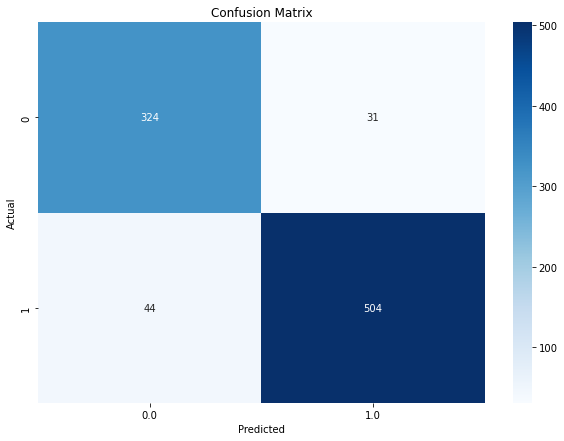

Precision: 0.94
Recall: 0.92
F1 Score: 0.93


In [21]:
from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt


#indexer = StringIndexer(inputCol="label", outputCol="indexedLabel", handleInvalid="keep")
#indexed_predictions = indexer.fit(predictions).transform(predictions)


# Calculate the confusion matrix
confusion_matrix = predictions.groupBy("continued_funding", "prediction").count()

# Extract true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN)
TP = confusion_matrix.filter((col("continued_funding") == 1) & (col("prediction") == 1)).select("count").first()[0]
TN = confusion_matrix.filter((col("continued_funding") == 0) & (col("prediction") == 0)).select("count").first()[0]
FP = confusion_matrix.filter((col("continued_funding") == 0) & (col("prediction") == 1)).select("count").first()[0]
FN = confusion_matrix.filter((col("continued_funding") == 1) & (col("prediction") == 0)).select("count").first()[0]

# Calculate precision, recall, and F1 score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)


# Convert confusion matrix to pandas dataframe for seaborn
confusion_matrix_df = confusion_matrix.toPandas()

# Pivot the dataframe to get the matrix format
confusion_matrix_pivot = confusion_matrix_df.pivot(index='continued_funding', columns='prediction', values='count').fillna(0)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix_pivot, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the evaluation metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

### AFV

In [7]:
from pyspark.sql import functions as F
df_8 = df_5.drop("total_funding", "num_of_funding_rounds", "continued_funding")
for i in range(1, max_rounds + 1):
    df_8 = df_8.drop(f"{i}_amount", f"{i}_type", f"{i}_valuation")

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Split the data into training and test sets
train_data, test_data = df_8.randomSplit([0.8, 0.2], seed=421312)
print([f'{col}_processed' for col in train_data.columns if col not in {"id", "org_valuation"}])


# Define the complete pipeline
complete_pipeline_model = complete_pipeline(train_data).fit(train_data)

# Assemble all the features into one column
assembler = VectorAssembler(
    inputCols=[
        f"{col}_processed"
        for col in train_data.columns
        if col
        not in {
            "id",
            "org_valuation"
        }
    ],
    outputCol="features",
)

# Create a pipeline to apply the complete pipeline, assembler
final_pipeline = Pipeline(stages=[complete_pipeline_model, assembler])

# Fit the pipeline to the training data
pipeline_model = final_pipeline.fit(train_data)

# Transform the training and test data
train_data = pipeline_model.transform(train_data)
test_data = pipeline_model.transform(test_data)

# Select the relevant columns
train_data = train_data.select("features","id", "org_valuation")
test_data = test_data.select("features","id", "org_valuation")

In [45]:
from pyspark.ml.regression import GBTRegressor

# Initialize the GradientBoostedTreeRegressor
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="org_valuation",
    predictionCol="prediction",
    maxDepth=15,
    maxBins=256,
    minInstancesPerNode=5,
    minInfoGain=0.01,
    subsamplingRate=0.8,
    maxIter=100
)

# Fit the model to the training data
gbt_model = gbt.fit(train_data)

# Make predictions on the test data
predictions = gbt_model.transform(test_data)

+--------------------+--------------------+-------------+--------------------+
|            features|                  id|org_valuation|          prediction|
+--------------------+--------------------+-------------+--------------------+
|(5831,[376,1664,1...|         1stdibs-(4)|       2.53E8|2.4037289941165435E8|
|(5831,[678,1391,1...| ableinnovations-(1)|    3500000.0|-6.16744026795654...|
|(5831,[589,1667,1...|abnormal-security...|        7.4E7|1.4579715659950197E8|
|(5831,[485,3000,3...|    academia-edu-(1)|      2.229E8| 2.100664749766748E8|
|(5831,[485,3000,3...|    academia-edu-(2)|      2.229E8| 2.100664749766748E8|
|(5831,[485,3000,3...|    academia-edu-(3)|      2.229E8| 2.100664749766748E8|
|(5831,[375,1520,1...|           acast-(0)|      1.567E8|1.5126504755593976E8|
|(5831,[375,1520,1...|           acast-(1)|      1.567E8|1.5126504755593976E8|
|(5831,[3001,3002,...|      accredible-(0)|     150000.0|6.4436373105075255E7|
|(5831,[646,1562,1...|          acorns-(0)|        1

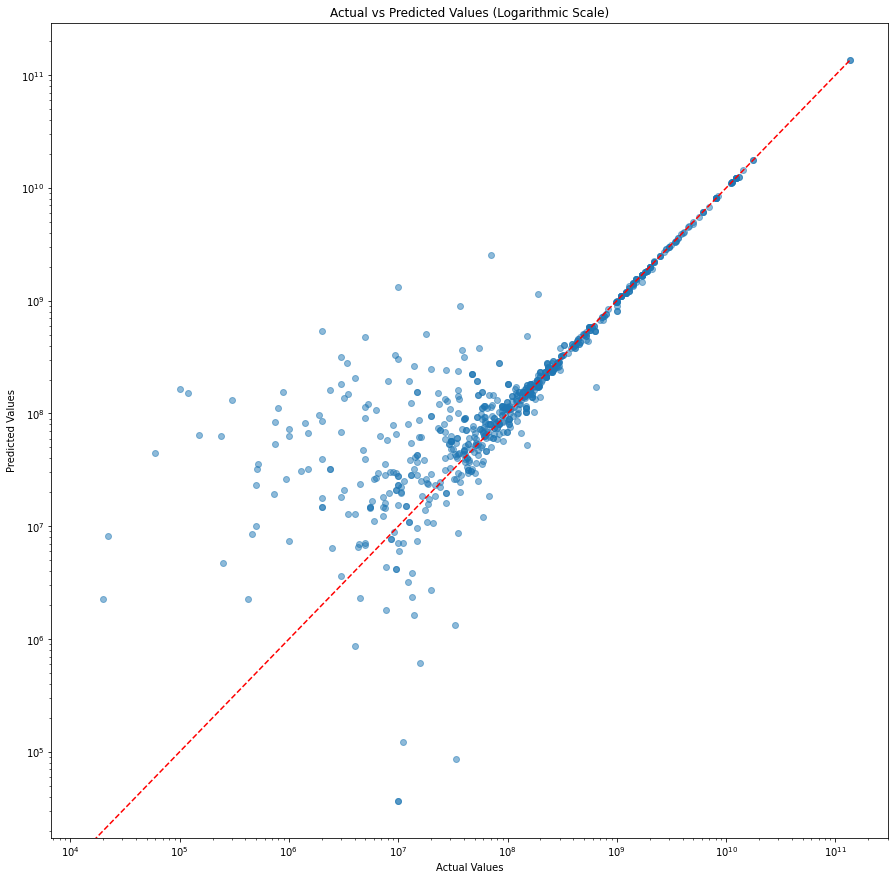

In [46]:
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

predictions.show()

# Initialize the evaluator
evaluator = RegressionEvaluator(labelCol='org_valuation', predictionCol='prediction', metricName='rmse')

# Evaluate the model on the test data
rmse = evaluator.evaluate(predictions)

# Print the RMSE
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Convert predictions to a Pandas DataFrame
predictions_df = predictions.select('prediction', 'org_valuation').toPandas()

# Plot the actual vs predicted values on a logarithmic scale
plt.figure(figsize=(15, 15))
plt.loglog(predictions_df['org_valuation'], predictions_df['prediction'], 'o', alpha=0.5)
plt.plot([predictions_df['org_valuation'].min(), predictions_df['org_valuation'].max()],
         [predictions_df['org_valuation'].min(), predictions_df['org_valuation'].max()],
         color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Logarithmic Scale)')
plt.show()


### AFT

In [8]:
from pyspark.sql import functions as F
df_7 = df_5.withColumn("continued_funding_type", F.col("1_type"))
df_7 = df_7.drop(
    "continued_funding", "1_amount", "1_type", "total_funding"
)
df_7.show()

+--------------------+--------------------+--------------------+--------------------+----------------+-------------+---------------------+-----------+---------+--------+-----------+---------+--------+-----------+---------+--------+-----------+---------+--------+-----------+---------+--------+-----------+--------+--------+-----------+--------+--------+-----------+--------+------+-----------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+--------------------+--------------------+--------------------+----------------------+
|                  id|                name|              slogan|         description|            size|org_valuation|num_of_funding_rounds|1_valuation| 2_amount|  2_type|2_valuatio

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexerModel
from pyspark.ml import Pipeline

# Split the data into training and test sets
train_data, test_data = df_7.randomSplit([0.8, 0.2], seed=421312)
print([f'{col}_processed' for col in train_data.columns if col not in {"id", "continued_funding_type"}])


# Define the complete pipeline
complete_pipeline_model = complete_pipeline(train_data).fit(train_data)

# Assemble all the features into one column
assembler = VectorAssembler(
    inputCols=[
        f"{col}_processed"
        for col in train_data.columns
        if col
        not in {
            "id",
            "continued_funding_type"
        }
    ],
    outputCol="features",
)

In [27]:
# Index the label column
label_indexer = StringIndexerModel.from_labels(
    [
        "IPO",
        "Series C",
        "Series G",
        "Series B2",
        "Series B",
        "Series X",
        "Series E1",
        "Series Later Stage VC",
        "Series Unknown",
        "Series Unknown Early Stage",
        "SPAC",
        "Series F-2",
        "Series B Extension",
        "Series H",
        "Series E",
        "NONE",
        "Series I",
        "Series C Extension",
        "Series - Debt Financing",
        "Series D Extension",
        "Series C2",
        "Series D",
        "Series Bootstrapped",
        "Series Rolling SAFE",
        "Series Growth",
        "Series Post-IPO Equity",
        "Unknown",
        "Other",
        "Series D2",
        "Acquired",
        "Series Unknown Extension",
        "Series Private Equity",
        "Seed",
        "Series",
        "Series Self-Funded",
        "Series A-2",
        "Series Bootstrapped & Profitable",
        "Series A",
        "Series D1",
        "Series Pre-A",
        "Series F",
        "Series A-1",
        "Series Unknown Later Stage",
        "Series NIH",
        "Series Convertible Note",
        "Closed",
        "Series Grant",
        "Series Venture",
        "Pre-Seed",
        "Series Funding Round",
        "Series Venture Round",
        "Series B1",
        "Series Debt Financing",
    ],
    inputCol="continued_funding_type",
    outputCol="label",
)

# Create a pipeline to apply the complete pipeline, assembler
final_pipeline = Pipeline(stages=[complete_pipeline_model, assembler])

# Fit the pipeline to the training data
pipeline_model = final_pipeline.fit(train_data)

# Transform the training and test data
train_data = pipeline_model.transform(train_data)
test_data = pipeline_model.transform(test_data)

train_data = label_indexer.transform(train_data)
test_data = label_indexer.transform(test_data)

# Select the relevant columns
train_data = train_data.select("features","id","label")
test_data = test_data.select("features","id","label")

In [28]:
from pyspark.ml.classification import LogisticRegression

# Initialize the LogisticRegression classifier
lr = LogisticRegression(featuresCol='features', labelCol='label', predictionCol='prediction')

# Fit the model to the training data
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

+--------------------+--------------------+-----+--------------------+--------------------+----------+
|            features|                  id|label|       rawPrediction|         probability|prediction|
+--------------------+--------------------+-----+--------------------+--------------------+----------+
|(6860,[377,1654,1...|         1stdibs-(4)| 37.0|[0.16061774387587...|[9.31492883228516...|      26.0|
|(6860,[678,1391,1...| ableinnovations-(1)| 48.0|[-1.7447741700490...|[2.27823760974202...|      32.0|
|(6860,[589,1666,1...|abnormal-security...|  4.0|[2.86553715045853...|[1.84339275940732...|      37.0|
|(6860,[480,2924,3...|    academia-edu-(1)|  1.0|[6.92049447265583...|[5.67366150351667...|       4.0|
|(6860,[480,2924,3...|    academia-edu-(2)| 26.0|[7.46341685017731...|[4.61699333066996...|      26.0|
+--------------------+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



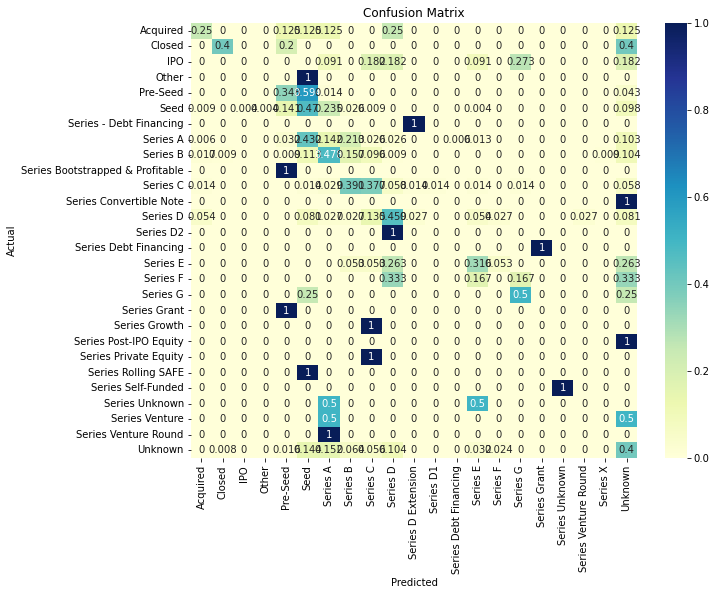

Weighted F1 Score: 0.3122979205988516


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create a list where at index 'i' is the meta industry represented by the label 'i'
predictions.show(5)


# Transform the prediction column to a string according to the continued_funding_type
index_tostring_model = IndexToString(inputCol="prediction", outputCol="predicted_continued_funding_type", labels=label_indexer.labels)
predictions = index_tostring_model.transform(predictions)
index_tostring_model = IndexToString(inputCol="label", outputCol="continued_funding_type", labels=label_indexer.labels)
predictions = index_tostring_model.transform(predictions)
confusion_matrix = predictions.groupBy("continued_funding_type", "predicted_continued_funding_type").count()

# Normalize the confusion matrix so that the sum of each row is 1
confusion_matrix = confusion_matrix.withColumn("row_sum", F.sum("count").over(Window.partitionBy("continued_funding_type")))
confusion_matrix = confusion_matrix.withColumn("normalized_count", (col("count") / col("row_sum")).cast("double"))
confusion_matrix = confusion_matrix.withColumn("normalized_count", F.round(col("normalized_count"), 3))
# Convert the confusion matrix to a Pandas DataFrame
confusion_matrix_pd = confusion_matrix.toPandas()

# Pivot the DataFrame to get the matrix format
confusion_matrix_pivot = confusion_matrix_pd.pivot(index='continued_funding_type', columns='predicted_continued_funding_type', values='normalized_count').fillna(0)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_pivot, annot=True, fmt="g", cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


# Step 6: Evaluate the Model using Weighted F1 Score
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedFMeasure"
)

# Compute the weighted F1 score
weighted_f1_score = evaluator.evaluate(predictions)
print(f"Weighted F1 Score: {weighted_f1_score}")

### AFC

In [9]:
from pyspark.sql import functions as F
df_6 = df_5.withColumn("continued_funding_amount", F.col("1_amount"))
df_6 = df_6.drop("continued_funding","1_amount","total_funding")
df_6 = df_6.filter(F.col("continued_funding_amount") != 0)
df_6 = (
    df_6.withColumn(
        "cast_continued_funding_amount",
        F.col("continued_funding_amount").cast(IntegerType()),
    )
    .drop("continued_funding_amount")
    .withColumnRenamed("cast_continued_funding_amount", "continued_funding_amount")
)
df_6.show()

+------------------+--------------+--------------------+--------------------+----------------+-------------+---------------------+--------+-----------+---------+--------+-----------+---------+--------+-----------+---------+--------+-----------+---------+--------+-----------+---------+--------+-----------+---------+--------+-----------+--------+--------+-----------+---------+------+-----------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+--------------------+-----------+--------------------+------------------------+
|                id|          name|              slogan|         description|            size|org_valuation|num_of_funding_rounds|  1_type|1_valuation| 2_amount|  2_type|2_valuation| 

In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Split the data into training and test sets
train_data, test_data = df_6.randomSplit([0.8, 0.2], seed=421312)
print([f'{col}_processed' for col in train_data.columns if col not in {"id", "continued_funding_amount"}])


# Define the complete pipeline
complete_pipeline_model = complete_pipeline(train_data).fit(train_data)

# Assemble all the features into one column
assembler = VectorAssembler(
    inputCols=[
        f"{col}_processed"
        for col in train_data.columns
        if col
        not in {
            "id",
            "continued_funding_amount"
        }
    ],
    outputCol="features",
)

# Create a pipeline to apply the complete pipeline, assembler
final_pipeline = Pipeline(stages=[complete_pipeline_model, assembler])

# Fit the pipeline to the training data
pipeline_model = final_pipeline.fit(train_data)

# Transform the training and test data
train_data = pipeline_model.transform(train_data)
test_data = pipeline_model.transform(test_data)

# Select the relevant columns
train_data = train_data.select("features","id", "continued_funding_amount")
test_data = test_data.select("features","id", "continued_funding_amount")

['name_processed', 'slogan_processed', 'description_processed', 'size_processed', 'org_valuation_processed', 'num_of_funding_rounds_processed', '1_type_processed', '1_valuation_processed', '2_amount_processed', '2_type_processed', '2_valuation_processed', '3_amount_processed', '3_type_processed', '3_valuation_processed', '4_amount_processed', '4_type_processed', '4_valuation_processed', '5_amount_processed', '5_type_processed', '5_valuation_processed', '6_amount_processed', '6_type_processed', '6_valuation_processed', '7_amount_processed', '7_type_processed', '7_valuation_processed', '8_amount_processed', '8_type_processed', '8_valuation_processed', '9_amount_processed', '9_type_processed', '9_valuation_processed', '10_amount_processed', '10_type_processed', '10_valuation_processed', '11_amount_processed', '11_type_processed', '11_valuation_processed', '12_amount_processed', '12_type_processed', '12_valuation_processed', '13_amount_processed', '13_type_processed', '13_valuation_process

In [18]:
from pyspark.ml.regression import RandomForestRegressor

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="continued_funding_amount",
    predictionCol="prediction",
    numTrees=300,
    maxDepth=20,
    maxBins=256,
    minInstancesPerNode=15,
    minInfoGain=0.08,
    subsamplingRate=0.7,
)

# Fit the model to the training data
rf_model = rf.fit(train_data)

# Make predictions on the test data
predictions = rf_model.transform(test_data)

+--------------------+--------------------+------------------------+--------------------+
|            features|                  id|continued_funding_amount|          prediction|
+--------------------+--------------------+------------------------+--------------------+
|(6883,[314,1665,1...|         1stdibs-(3)|                42000000|1.0960525216287479E8|
|(6883,[3,483,1502...|abl-space-systems...|                47540532|3.5779394659606636E7|
|(6883,[898,1650,2...| ableinnovations-(0)|                 2000000|   3938716.551414051|
|(6883,[227,1037,1...|abnormal-security...|                24000000|2.0606981180872884E7|
|(6883,[280,2649,3...|    academia-edu-(0)|                23000000|6.1252486185549885E7|
|(6883,[280,2649,3...|    academia-edu-(1)|                16000000| 4.882458121667747E7|
|(6883,[1117,1509,...|    academiclabs-(0)|                  900000|   2675407.678754284|
|(6883,[1117,1509,...|    academiclabs-(1)|                 1124000|  2327017.4955468867|
|(6883,[14

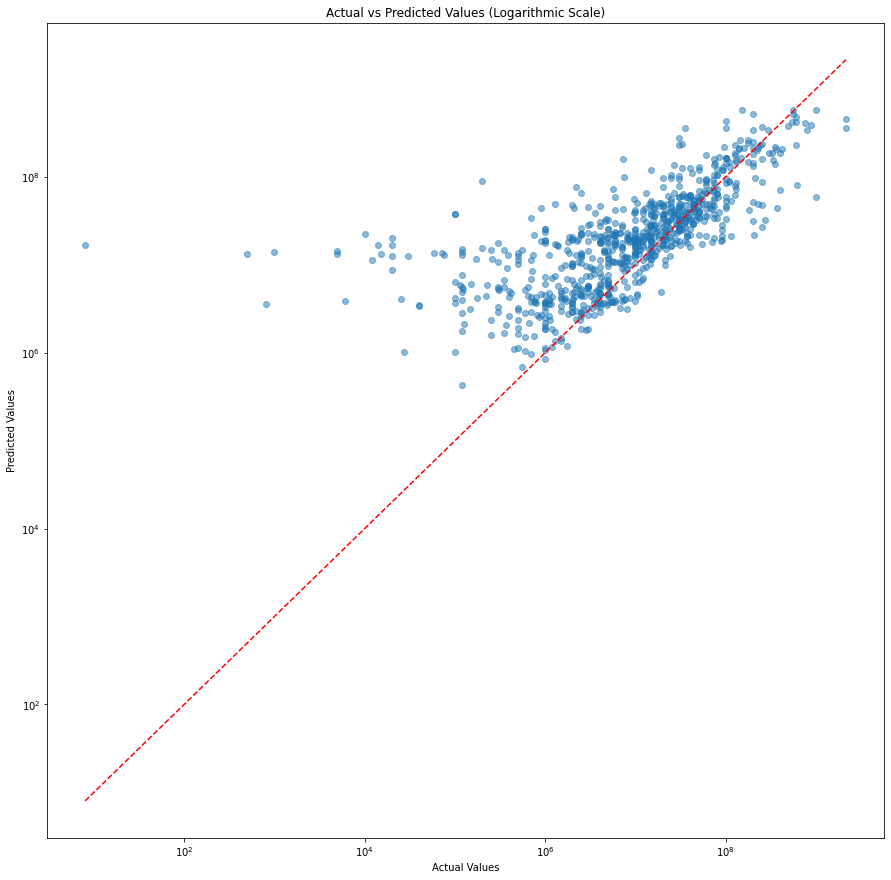

In [19]:
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

predictions.show()

# Initialize the evaluator
evaluator = RegressionEvaluator(labelCol='continued_funding_amount', predictionCol='prediction', metricName='rmse')

# Evaluate the model on the test data
rmse = evaluator.evaluate(predictions)

# Print the RMSE
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Convert predictions to a Pandas DataFrame
predictions_df = predictions.select('prediction', 'continued_funding_amount').toPandas()

# Plot the actual vs predicted values on a logarithmic scale
plt.figure(figsize=(15, 15))
plt.loglog(predictions_df['continued_funding_amount'], predictions_df['prediction'], 'o', alpha=0.5)
plt.plot([predictions_df['continued_funding_amount'].min(), predictions_df['continued_funding_amount'].max()],
         [predictions_df['continued_funding_amount'].min(), predictions_df['continued_funding_amount'].max()],
         color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Logarithmic Scale)')
plt.show()


## Final Models & Functions

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier

# Define the complete pipeline
complete_pipeline_model = complete_pipeline(df_5)

# Assemble all the features into one column
assembler = VectorAssembler(
    inputCols=[f'{col}_processed' for col in df_5.columns if col not in {"id", "continued_funding"}],
    outputCol="features"
)

# Initialize the GBTClassifier
gbt = GBTClassifier(featuresCol='features', labelCol='continued_funding', predictionCol='continued_funding_prediction', 
                    maxDepth=5, maxIter=200, stepSize=0.01, maxBins=128, 
                    minInstancesPerNode=1, minInfoGain=0.00, subsamplingRate=0.8)

# Create a pipeline to apply the complete pipeline, assembler, and GBTClassifier
final_pipeline = Pipeline(stages=[complete_pipeline_model, assembler, gbt])

# Fit the model to the training data
afb_model = final_pipeline.fit(df_5)
afb_model.write().overwrite().save("work/models/afb_model")

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

# Define the complete pipeline
afc_complete_pipeline_model = complete_pipeline(df_6)

# Assemble all the features into one column
assembler = VectorAssembler(
    inputCols=[f'{col}_processed' for col in df_6.columns if col not in {"id", "continued_funding_amount"}],
    outputCol="features"
)

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="continued_funding_amount",
    predictionCol="prediction",
    numTrees=300,
    maxDepth=20,
    maxBins=256,
    minInstancesPerNode=15,
    minInfoGain=0.08,
    subsamplingRate=0.7,
)

# Create a pipeline to apply the complete pipeline, assembler, and RandomForestRegressor
afc_final_pipeline = Pipeline(stages=[afc_complete_pipeline_model, assembler, rf])

# Fit the model to the training data
afc_model = afc_final_pipeline.fit(df_6)
afc_model.write().overwrite().save("work/models/afc_model")

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor

# Define the complete pipeline
afv_complete_pipeline_model = complete_pipeline(df_8)

# Assemble all the features into one column
assembler = VectorAssembler(
    inputCols=[f'{col}_processed' for col in df_8.columns if col not in {"id", "org_valuation"}],
    outputCol="features"
)

# Initialize the GradientBoostedTreeRegressor
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="org_valuation",
    predictionCol="prediction",
    maxDepth=15,
    maxBins=256,
    minInstancesPerNode=5,
    minInfoGain=0.01,
    subsamplingRate=0.8,
    maxIter=100
)

# Create a pipeline to apply the complete pipeline, assembler, and GBTRegressor
final_pipeline = Pipeline(stages=[afv_complete_pipeline_model, assembler, gbt])

# Fit the model to the training data
afv_model = final_pipeline.fit(df_8)
afv_model.write().overwrite().save("work/models/afv_model")

In [60]:
from pyspark.ml import PipelineModel

def prediction_processor(base_df, new_df):
    """
    This function is used to process the predictions from the binary classifier, returning a tuple of the non-continued funding companies and the continued funding companies
    """
    continued_funding_companies = new_df.filter(
        F.col("continued_funding_prediction") == 1
    )
    non_continued_funding_companies = new_df.filter(
        F.col("continued_funding_prediction") == 0
    )
    non_continued_funding_companies = non_continued_funding_companies.drop(
        "continued_funding_prediction"
    )
    if base_df.count() == 0:
        return non_continued_funding_companies, continued_funding_companies
    non_continued_funding_companies = base_df.union(non_continued_funding_companies.select(*base_df.columns))
    return non_continued_funding_companies, continued_funding_companies


def prediction_amount_processor(df):
    """
    This function is used to reformat the funding amount prediction dataframe so that it can be re-inputted into the model for further imputation.
    Specifically, it shifts the amount, type, valuation columns by 1, and drops columns past index 20. In other words, {i}_type becomes {i+1}_type
    and if i+1 > 20, the column is dropped.
    Then, 1_amount is filled with the prediction column, 1_type is filled with "Unknown", and 1_valuation is filled with 0.
    All unnecessary columns are dropped and the dataframe is returned.
    """
    # Shift the columns by 1
    for i in range(20, 0, -1):
        df = df.withColumnRenamed(f"{i}_amount", f"{i+1}_amount")
        df = df.withColumnRenamed(f"{i}_type", f"{i+1}_type")
        df = df.withColumnRenamed(f"{i}_valuation", f"{i+1}_valuation")

    df = df.drop(f"{21}_amount", f"{21}_type", f"{21}_valuation")

    # Fill 1_amount with the prediction column
    df = df.withColumn("1_amount", df["prediction"])

    # Fill 1_type with "Unknown"
    df = df.withColumn("1_type", lit("Unknown"))

    # Fill 1_valuation with 0
    df = df.withColumn("1_valuation", lit(0))

    # Drop unnecessary columns
    df = df.drop("prediction")

    return df


def imputation_processor(base_df):
    """
    This function is used to process the predictions from the regression model, returning a tuple of the base dataframe and the new dataframe with imputed values.
    """
    afb_model = PipelineModel.load("work/models/afb_model")
    afc_model = PipelineModel.load("work/models/afc_model")
    afv_model = PipelineModel.load("work/models/afv_model")

    afv_predictions = afv_model.transform(
        base_df.filter(F.col("org_valuation") == 0)
    ).select("id", "prediction")
    base_df = (
        base_df.join(afv_predictions, on="id", how="left")
        .withColumn(
            "org_valuation", F.coalesce(F.col("prediction"), F.col("org_valuation"))
        )
        .drop("prediction")
        .withColumn(
            "org_valuation",
            F.when(F.col("org_valuation") < 0, None).otherwise(F.col("org_valuation")),
        )
        .withColumn(
            "new_org_valuation",
            F.coalesce(
                F.col("org_valuation"),
                F.lit(0),
            ),
        )
        .drop("org_valuation")
        .withColumnRenamed("new_org_valuation", "org_valuation")
    )

    base_df = base_df.drop("funding_rounds")
    imputed_df = base_df.filter(F.col("num_of_funding_rounds") == 0)
    finished_imputation = base_df.filter(F.col("num_of_funding_rounds") > 0)
    print(f"needs_imputation count: {imputed_df.count()}; finished_imputation count: {finished_imputation.count()}")

    for i in range(3):
        print(f"Imputation Round {i+1}, finished_imputation count: {finished_imputation.count()}")
        afb_predictions = afb_model.transform(imputed_df).select(*imputed_df.columns, "continued_funding_prediction")
        finished_imputation, continued_imputation = prediction_processor(
            finished_imputation, afb_predictions
        )
        print(f"Now processing:\n\t continued_imputation count: {continued_imputation.count()};\n\t finished_imputation count: {finished_imputation.count()}")
        if continued_imputation.count() == 0:
            break
        afc_predictions = afc_model.transform(
            continued_imputation.withColumn("continued_funding_amount", F.lit(0))
        )
        imputed_df = prediction_amount_processor(afc_predictions).select(*finished_imputation.columns).drop("continued_funding_prediction")
        imputed_df = (
            imputed_df.withColumn(
                "new_num_of_funding_rounds", F.col("num_of_funding_rounds") + 1
            )
            .drop("num_of_funding_rounds")
            .withColumnRenamed("new_num_of_funding_rounds", "num_of_funding_rounds")
        )
        imputed_df = (
            imputed_df.withColumn(
                "new_total_funding", F.col("total_funding") + F.col("1_amount")
            )
            .drop("total_funding")
            .withColumnRenamed("new_total_funding", "total_funding")
        )
        imputed_df.show(1)
    return finished_imputation.union(imputed_df.select(*finished_imputation.columns))

In [41]:
df_to_process = wellfound_companies.withColumnRenamed("type", "org_type").withColumnRenamed("valuation", "org_valuation")
df_to_process = generic_text_preprocessing(df_to_process, "name")
df_to_process = generic_text_preprocessing(df_to_process, "slogan")
df_to_process = generic_text_preprocessing(df_to_process, "description")
df_to_process = generic_array_preprocessing(df_to_process, "locations")
df_to_process = generic_categorical_preprocessing(df_to_process, "size")
df_to_process = generic_array_preprocessing(df_to_process, "org_type")
df_to_process = generic_array_preprocessing(df_to_process, "industries")
df_to_process = generic_numeric_preprocessing(df_to_process, "org_valuation")
df_to_process = generic_numeric_preprocessing(df_to_process, "total_funding")
df_to_process = generic_numeric_preprocessing(df_to_process, "num_of_funding_rounds").filter(F.col("num_of_funding_rounds") == 0)
for i in range(1, max_rounds + 1):
    df_to_process = df_to_process.withColumn(f"{i}_amount", F.lit(0))
    df_to_process = df_to_process.withColumn(f"{i}_type", F.lit("NONE"))
    df_to_process = df_to_process.withColumn(f"{i}_valuation", F.lit(0))
    df_to_process = generic_numeric_preprocessing(df_to_process, f"{i}_amount")
    df_to_process = generic_categorical_preprocessing(df_to_process, f"{i}_type")
    df_to_process = generic_numeric_preprocessing(df_to_process, f"{i}_valuation")

In [61]:
imputed_df = imputation_processor(df_to_process)
print(imputed_df.count())
# Save the DataFrame to disk in Parquet format
imputed_df.write.mode("overwrite").parquet("work/dataframes/imputed_df2.parquet")

needs_imputation count: 2373; finished_imputation count: 0
Imputation Round 1, finished_imputation count: 0
Now processing:
	 continued_imputation count: 1445;
	 finished_imputation count: 928
+-------------+-------------+--------------------+--------------------+-------------+--------------------+--------------------+-------------+--------+--------------------+-------------------+-------+-----------+--------+------+-----------+--------+------+-----------+--------+------+-----------+--------+------+-----------+--------+------+-----------+--------+------+-----------+--------+------+-----------+--------+------+-----------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+---------+-------+------------+-------------------+-----------

In [62]:
from pyspark.sql.functions import regexp_replace

non_imputed_df = df_5.filter(F.col("id").endswith("-(0)")).drop("continued_funding")
non_imputed_df = non_imputed_df.withColumn("id", regexp_replace("id", "-\\(0\\)", ""))
final_wf_df = non_imputed_df.union(imputed_df.select(*non_imputed_df.columns))
print(f"final wellfound companies count: {final_wf_df.count()}\n\t non-imputed companies count: {non_imputed_df.count()}\n\t imputed companies count: {imputed_df.count()}")
final_wf_df.write.mode("overwrite").parquet("work/dataframes/final_wf_df.parquet")

final wellfound companies count: 3962
	 non-imputed companies count: 1589
	 imputed companies count: 2373


# LinkedIn

In [5]:
import pyspark.sql.functions as F

full_wf_companies = spark.read.parquet("work/dataframes/final_wf_df.parquet")
funding_rounds_list = [f"{i}_amount" for i in range(1, 11)]
funding_rounds_list.extend([f"{i}_type" for i in range(1, 11)])
full_wf_companies = full_wf_companies.select(
    "id",
    "name",
    "slogan",
    "description",
    "size",
    "org_valuation",
    "industries",
    "num_of_funding_rounds",
    *funding_rounds_list,
)
full_wf_companies = full_wf_companies.withColumn("id", F.regexp_replace("id", "-\\(0\\)", ""))
full_wf_companies = full_wf_companies.filter(
    F.col("slogan").isNotNull()
    & F.col("description").isNotNull()
    & F.col("size").isNotNull()
    & F.col("industries").isNotNull()
    & F.col("org_valuation").isNotNull()
    & F.col("num_of_funding_rounds").isNotNull()
    & F.col("industries").isNotNull()
)

linkedin_companies = spark.read.parquet('data/Datalab-data/dbfs/linkedin_train_data')
linkedin_companies = linkedin_companies.select(
    "company_id",
    "slogan",
    "name",
    "about",
    "company_size",
    "industries",
    "funding",
)
linkedin_companies = linkedin_companies.filter(F.col("about").isNotNull()
                                               & F.col("industries").isNotNull() 
                                               & F.col("company_size").isNotNull() 
                                               & F.col("slogan").isNotNull())
linkedin_companies = (
    linkedin_companies.withColumnRenamed("company_id", "id")
    .withColumnRenamed("about", "description")
    .withColumnRenamed("company_size", "size")
)
linkedin_companies = linkedin_companies.withColumn(
    "size",
    F.when(F.col("size") == "1 employee", "1-10 people")
    .when(F.col("size") == "2-10 employees", "1-10 people")
    .when(F.col("size") == "11-50 employees", "11-50 people")
    .when(F.col("size") == "51-200 employees", "51-200 people")
    .when(F.col("size") == "201-500 employees", "201-500 people")
    .when(F.col("size") == "501-1,000 employees", "501-1000 people")
    .when(F.col("size") == "1,001-5,000 employees", "1001-5000 people")
    .when(F.col("size") == "5,001-10,000 employees", "5000+ people")
    .when(F.col("size") == "10,001+ employees", "5000+ people")
    .otherwise(F.col("size")),
)

print(f"LinkedIn company count: {linkedin_companies.count()}")
print(f"Wellfound company count: {full_wf_companies.count()}")

linkedin_companies.show(5)
full_wf_companies.show(5)

LinkedIn company count: 135571
Wellfound company count: 3962
+--------+--------------------+--------------------+--------------------+------------+--------------------+-------+
|      id|              slogan|                name|         description|        size|          industries|funding|
+--------+--------------------+--------------------+--------------------+------------+--------------------+-------+
|40754182|Your Personal Dig...|       MBC Workshop™|! Miniature Base ...| 1-10 people| Artists and Writers|   null|
|28602496|BARTLETT ARCHITEC...|Bartlett Design C...|!!!2015, 2016, 20...| 1-10 people|        Construction|   null|
|26582223|Challenge yoursel...|  $105,000 Challenge|" Challenge yours...| 1-10 people|Advertising Services|   null|
| 1961106|Las Vegas #1 Even...|Sienna Entertainment|" Las Vegas #1 VI...|11-50 people|         Hospitality|   null|
|20494441|We provide high-q...|The Auto Service-TAS|" We provide high...| 1-10 people|Motor Vehicle Man...|   null|
+--------+-

## Valuation Imputation

In [6]:
wf_df_1 = full_wf_companies.select(
    "id", "name", "slogan", "description", "size", "industries", "org_valuation"
)
wf_df_1 = generic_text_preprocessing(wf_df_1, "name")
wf_df_1 = generic_text_preprocessing(wf_df_1, "slogan")
wf_df_1 = generic_text_preprocessing(wf_df_1, "description")
wf_df_1 = generic_categorical_preprocessing(wf_df_1, "size")
wf_df_1 = generic_text_preprocessing(wf_df_1, "industries")
wf_df_1 = generic_numeric_preprocessing(wf_df_1, "org_valuation")
wf_df_1 = wf_df_1.filter(F.col("org_valuation") != 0)

### Model Selection

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Split the data into training and test sets
train_data, test_data = wf_df_1.randomSplit([0.8, 0.2], seed=421312)
print([f'{col}_processed' for col in train_data.columns if col not in {"id", "org_valuation"}])

# Define the complete pipeline
complete_pipeline_model = complete_pipeline(train_data).fit(train_data)

# Assemble all the features into one column
assembler = VectorAssembler(
    inputCols=[f'{col}_processed' for col in train_data.columns if col not in {"id", "org_valuation"}],
    outputCol="features"
)

# Create a pipeline to apply the complete pipeline, assembler
final_pipeline = Pipeline(stages=[complete_pipeline_model, assembler])

# Fit the pipeline to the training data
pipeline_model = final_pipeline.fit(train_data)

# Transform the training and test data
train_data = pipeline_model.transform(train_data)
test_data = pipeline_model.transform(test_data)

# Select the relevant columns
train_data = train_data.select("features","id", "org_valuation")
test_data = test_data.select("features","id", "org_valuation")

['name_processed', 'slogan_processed', 'description_processed', 'size_processed', 'industries_processed']
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [22]:
from pyspark.ml.regression import GBTRegressor

# Initialize the GBTRegressor with tuned parameters
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="org_valuation",
    predictionCol="prediction",
    maxIter=200,  # Increase the number of iterations
    stepSize=0.05,
    maxDepth=15,  # Increase the maximum depth of the trees 15
    subsamplingRate=0.8,  # Use a higher subsampling rate
    maxBins=256,  # Increase the number of bins 256
)

# Fit the model to the training data
gbt_model = gbt.fit(train_data)

# Make predictions on the test data
predictions = gbt_model.transform(test_data).drop("features")

+--------------------+---------------+--------------------+
|                  id|  org_valuation|          prediction|
+--------------------+---------------+--------------------+
|   abnormal-security|          7.4E7|3.1487818193865175E9|
|            agent-iq|         1.85E7|3.1917086407613546E7|
|               agolo|      3600000.0|1.8227060271058083E7|
|            aiplanet|       511000.0|2.3845273524723634E7|
|              airbnb|1.1299999744E10|1.095171413046151...|
|           airbyte-1|          1.5E9|1.4472541471786812E8|
|           alarm-com|         1.63E8|1.5087258136359385E8|
|           alayacare|         1.21E8| 2.908202627071207E7|
|            allbirds|          1.4E9| 6.711257904443032E7|
|             alluxio|         5.75E7|1.3404942730935875E8|
|             alma-14|          1.3E8|1.9459816029013696E8|
|             aloware|      1000000.0|  369572.73585335165|
|        altana-trade|          1.0E8|2.5680835889083028E7|
| ambience-healthcare|          3.0E7|1.

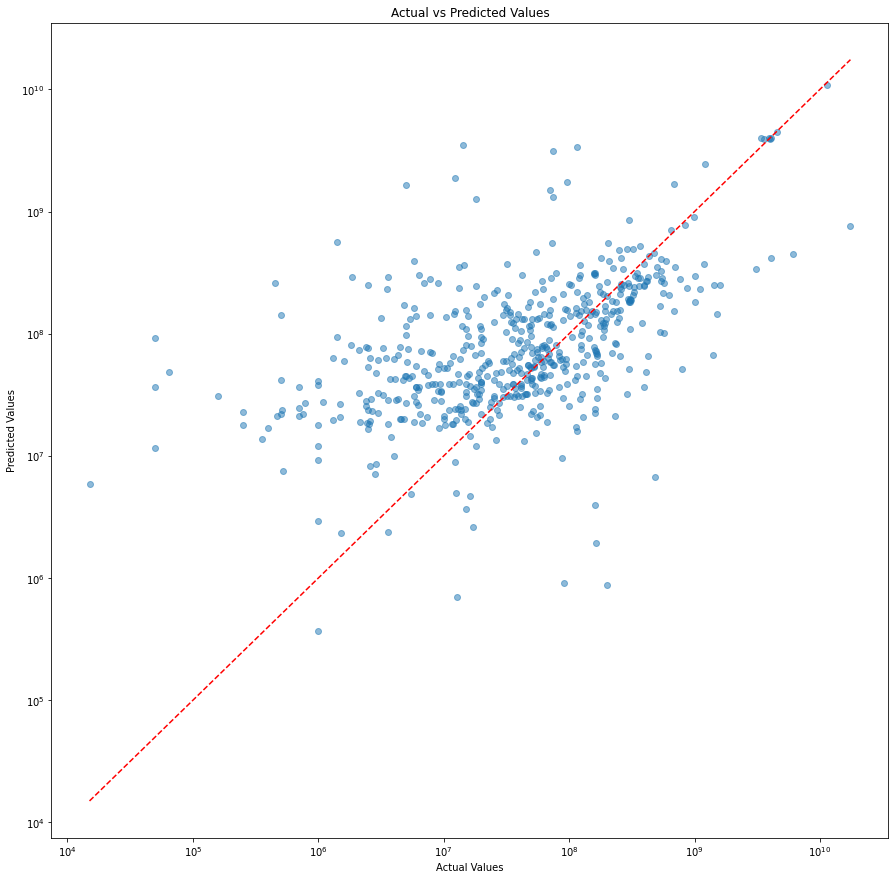

In [23]:
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

predictions.show()

negative_predictions_percentage = (predictions.filter(predictions.prediction < 0).count() / predictions.count()) * 100
print(f"Percentage of negative predictions: {negative_predictions_percentage:.2f}%")

negative_org_valuation_percentage = (predictions.filter(predictions.org_valuation < 0).count() / predictions.count()) * 100
print(f"Percentage of negative org_valuation: {negative_org_valuation_percentage:.2f}%")

predictions = predictions.filter(predictions.prediction >= 0)

# Initialize the evaluator
evaluator = RegressionEvaluator(labelCol='org_valuation', predictionCol='prediction', metricName='rmse')

# Evaluate the model on the test data
rmse = evaluator.evaluate(predictions)

# Print the RMSE
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Convert predictions to a Pandas DataFrame
predictions_df = predictions.select('prediction', 'org_valuation').toPandas()

# Plot the actual vs predicted values on a logarithmic scale
plt.figure(figsize=(15, 15))
plt.scatter(predictions_df['org_valuation'], predictions_df['prediction'], alpha=0.5)
plt.plot([predictions_df['org_valuation'].min(), predictions_df['org_valuation'].max()],
         [predictions_df['org_valuation'].min(), predictions_df['org_valuation'].max()],
         color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.xscale('symlog')
plt.yscale('symlog')
plt.show()

### Final Model

In [24]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor

# Define the complete pipeline
ilv_complete_pipeline_model = complete_pipeline(wf_df_1)

# Assemble all the features into one column
assembler = VectorAssembler(
    inputCols=[f'{col}_processed' for col in wf_df_1.columns if col not in {"id", "org_valuation", "funding"}],
    outputCol="features"
)

# Initialize the GradientBoostedTreeRegressor
# Initialize the GBTRegressor with tuned parameters
# Initialize the GBTRegressor with tuned parameters
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="org_valuation",
    predictionCol="prediction",
    maxIter=200,  # Increase the number of iterations
    stepSize=0.05,
    maxDepth=15,  # Increase the maximum depth of the trees 15
    subsamplingRate=0.8,  # Use a higher subsampling rate
    maxBins=256,  # Increase the number of bins 256
)

# Create a pipeline to apply the complete pipeline, assembler, and RandomForestRegressor
ilv_final_pipeline = Pipeline(stages=[ilv_complete_pipeline_model, assembler, gbt])

# Fit the model to the training data
ilv_model = ilv_final_pipeline.fit(wf_df_1)
ilv_model.write().overwrite().save("work/models/ilv_model")

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


### Imputation

In [25]:
li_df_1 = linkedin_companies.select(
    "id", "name", "slogan", "description", "size", "industries", "funding"
)
li_df_1 = generic_text_preprocessing(li_df_1, "name")
li_df_1 = generic_text_preprocessing(li_df_1, "slogan")
li_df_1 = generic_text_preprocessing(li_df_1, "description")
li_df_1 = generic_categorical_preprocessing(li_df_1, "size")
li_df_1 = generic_text_preprocessing(li_df_1, "industries")
li_df_1.show(5)

+--------+--------------------+--------------------+--------------------+------------+--------------------+-------+
|      id|                name|              slogan|         description|        size|          industries|funding|
+--------+--------------------+--------------------+--------------------+------------+--------------------+-------+
|40754182|       MBC Workshop™|Your Personal Dig...|! Miniature Base ...| 1-10 people| Artists and Writers|   null|
|28602496|Bartlett Design C...|BARTLETT ARCHITEC...|!!!2015, 2016, 20...| 1-10 people|        Construction|   null|
|26582223|  $105,000 Challenge|Challenge yoursel...|" Challenge yours...| 1-10 people|Advertising Services|   null|
| 1961106|Sienna Entertainment|Las Vegas #1 Even...|" Las Vegas #1 VI...|11-50 people|         Hospitality|   null|
|20494441|The Auto Service-TAS|We provide high-q...|" We provide high...| 1-10 people|Motor Vehicle Man...|   null|
+--------+--------------------+--------------------+--------------------

In [26]:
from pyspark.ml import PipelineModel
import matplotlib.pyplot as plt

# Load the ilv_model
ilv_model = PipelineModel.load("work/models/ilv_model")

# Transform the li_df_1 using the loaded model
transformed_li_df_1 = ilv_model.transform(li_df_1.withColumn("org_valuation", F.lit(0)))

# Show the transformed dataframe
transformed_li_df_1 = transformed_li_df_1.select(*li_df_1.columns, "prediction").withColumnRenamed("prediction", "org_valuation")
transformed_li_df_1.show(5)

+--------+--------------------+--------------------+--------------------+------------+--------------------+-------+--------------------+
|      id|                name|              slogan|         description|        size|          industries|funding|       org_valuation|
+--------+--------------------+--------------------+--------------------+------------+--------------------+-------+--------------------+
|40754182|       MBC Workshop™|Your Personal Dig...|! Miniature Base ...| 1-10 people| Artists and Writers|   null| 3.844222019721726E7|
|28602496|Bartlett Design C...|BARTLETT ARCHITEC...|!!!2015, 2016, 20...| 1-10 people|        Construction|   null| 1.997286283279561E7|
|26582223|  $105,000 Challenge|Challenge yoursel...|" Challenge yours...| 1-10 people|Advertising Services|   null|1.8854720854760104E8|
| 1961106|Sienna Entertainment|Las Vegas #1 Even...|" Las Vegas #1 VI...|11-50 people|         Hospitality|   null| 2.176521277202337E7|
|20494441|The Auto Service-TAS|We provide

In [27]:
# Save the DataFrame to permanent storage in Parquet format
transformed_li_df_1.write.mode("overwrite").parquet("work/dataframes/linkedin_imputed_valuations.parquet")

## Funding Imputation

In [5]:
import pyspark.sql.functions as F

linkedin_imputed_valuations = spark.read.parquet("work/dataframes/linkedin_imputed_valuations.parquet")
linkedin_imputed_valuations = linkedin_imputed_valuations.filter(F.col("org_valuation") >= 0)

wf_imputed = spark.read.parquet("work/dataframes/final_wf_df.parquet")
for i in range(11, 21):
    wf_imputed = wf_imputed.drop(f"{i}_amount", f"{i}_type", f"{i}_valuation")
for i in range(1, 11):
    wf_imputed = wf_imputed.drop(f"{i}_valuation", f"{i}_type")
wf_imputed = wf_imputed.drop("total_funding", "locations", "org_type").withColumn("id", F.regexp_replace("id", "-\\(0\\)", ""))
wf_imputed = wf_imputed.filter(~F.col("id").rlike(r"-\(\d+\)$"))
funding_columns = [f"{i}_amount" for i in range(1, 11)]
wf_imputed = wf_imputed.withColumn("funding", sum(F.col(col) for col in funding_columns)).drop(*funding_columns)
#wf_imputed = wf_imputed.drop("benefits", "benefits_overview")

# Sort the dataframe according to id and show the first 20 rows
wf_imputed = wf_imputed.sort("id")
wf_imputed.show(5)

+---------+--------+--------------------+--------------------+-------------+--------------------+---------------------+--------------------+--------------------+
|       id|    name|              slogan|         description|         size|       org_valuation|num_of_funding_rounds|          industries|             funding|
+---------+--------+--------------------+--------------------+-------------+--------------------+---------------------+--------------------+--------------------+
|0xproject|      0x|Powering the peer...|0x is a protocol ...|51-200 people|3.4106690969743085E8|                    3|Cryptocurrency, B...| 1.839893443496326E8|
|    100ms|   100ms|Live video infras...|100ms is building...|51-200 people| 2.770744389538808E8|                    3|Video, Video Conf...|1.7191721177806252E8|
|100xgroup|    100x|Reshaping the mod...|100x Group explor...|51-200 people|1.0115950639167309E8|                    3|Security, Financi...|1.0839431477804722E8|
| 101-ways|101 Ways|Building

### Supplementary Funding Imputation

In [60]:
import pyspark.sql.functions as F

li_df_2 = linkedin_imputed_valuations.filter(F.col("funding").isNotNull())
li_df_2 = li_df_2.withColumn("num_of_funding_rounds", F.col("funding").getField("rounds")).drop("funding")
li_df_2.show(5)

+--------+------------------+--------------------+--------------------+--------------+--------------------+--------------------+---------------------+
|      id|              name|              slogan|         description|          size|          industries|       org_valuation|num_of_funding_rounds|
+--------+------------------+--------------------+--------------------+--------------+--------------------+--------------------+---------------------+
|10006986|      Genesis 1:11|        And God said|"And God said, Le...|   1-10 people|Environmental Ser...| 1.645944026849996E7|                    2|
|82017021|Allen Technologies|Achieved Success ...|"Doing it right t...|  11-50 people|         Oil and Gas|2.8474020162066534E7|                    1|
| 2067906|      SampleOn Inc|    Lead By a Sample|"Turning business...| 51-200 people|Software Development| 4.173664649353703E7|                    1|
| 3233827|     Villa of Hope|rebuild. recover....|"WE WILL TAKE CAR...|201-500 people|Individu

#### Model Selection

In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Split the data into training and test sets
train_data, test_data = wf_imputed.randomSplit([0.8, 0.2], seed=421312)
print([f'{col}_processed' for col in train_data.columns if col not in {"id", "funding"}])


# Define the complete pipeline
complete_pipeline_model = complete_pipeline(train_data).fit(train_data)

# Assemble all the features into one column
assembler = VectorAssembler(
    inputCols=[
        f"{col}_processed"
        for col in train_data.columns
        if col
        not in {
            "id",
            "funding"
        }
    ],
    outputCol="features",
)

# Create a pipeline to apply the complete pipeline, assembler
final_pipeline = Pipeline(stages=[complete_pipeline_model, assembler])

# Fit the pipeline to the training data
pipeline_model = final_pipeline.fit(train_data)

# Transform the training and test data
train_data = pipeline_model.transform(train_data)
test_data = pipeline_model.transform(test_data)

# Select the relevant columns
train_data = train_data.select("features","id", "funding")
test_data = test_data.select("features","id", "funding")

['name_processed', 'slogan_processed', 'description_processed', 'size_processed', 'org_valuation_processed', 'num_of_funding_rounds_processed', 'industries_processed']
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [7]:
from pyspark.ml.regression import GBTRegressor

# Initialize the GBTRegressor with tuned parameters
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="funding",
    predictionCol="prediction",
    maxIter=200,  # Increase the number of iterations
    stepSize=0.05,
    maxDepth=15,  # Increase the maximum depth of the trees
    subsamplingRate=0.8,  # Use a higher subsampling rate
    maxBins=256  # Increase the number of bins
)

# Fit the model to the training data
gbt_model = gbt.fit(train_data)

# Make predictions on the test data
predictions = gbt_model.transform(test_data).drop("features")

+---------------+-----------+--------------------+
|             id|    funding|          prediction|
+---------------+-----------+--------------------+
|ableinnovations|  3500000.0|   4911375.412043256|
|       aetion-7|    2.032E8|1.1086705566401811E8|
|           aeye|5.9085591E7| 6.993738653606337E7|
|       agent-iq|     1.85E7| 1.849393004941851E7|
|          agolo|  3590000.0|   3787220.879661012|
|     ai-fleet-1|     2.45E7|2.1391753409226194E7|
|        aircall|   1.0555E8|  2.42734393626236E8|
|           akqa|      2.0E8|   5744792.340423282|
|        albeado|  3000000.0|  1757515.8043831883|
|        algolia|   1.8412E8|1.8707905546090546E8|
|         allara|      1.0E7|   759733.1423276784|
|      alltrails|7.9484987E7|   4937717.517505461|
|        aloware|  1000000.0|   1115879.603734841|
| ambidextrous-3|      3.2E7|2.1909598313643087E7|
|   ambient-ai-1|      5.2E7| 4.854442114974905E7|
|       applovin|     4.04E8|  1.45877822770991E8|
|           aqai|   900000.0|1.

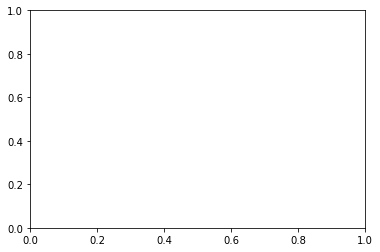

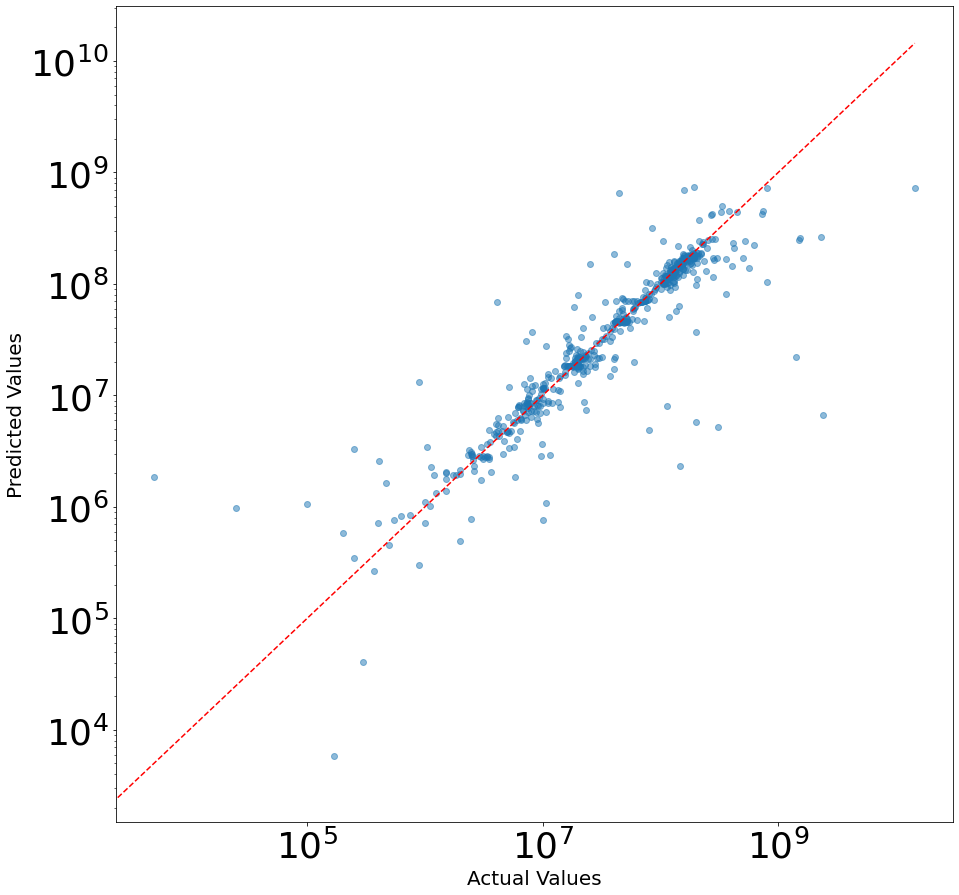

In [15]:
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

predictions.show()

negative_predictions_percentage = (predictions.filter(predictions.prediction < 0).count() / predictions.count()) * 100
print(f"Percentage of negative predictions: {negative_predictions_percentage:.2f}%")

# Filter out lower values
predictions = predictions.filter(predictions.prediction > 0)

# Initialize the evaluator
evaluator = RegressionEvaluator(labelCol='funding', predictionCol='prediction', metricName='rmse')

# Evaluate the model on the test data
rmse = evaluator.evaluate(predictions)

# Print the RMSE
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Convert predictions to a Pandas DataFrame
predictions_df = predictions.select('prediction', 'funding').toPandas()


# Apply ticklabel_format
plt.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))

# Plot the actual vs predicted values on a logarithmic scale
plt.figure(figsize=(15, 15))
plt.loglog(predictions_df['funding'], predictions_df['prediction'], 'o', alpha=0.5)
plt.plot([predictions_df['funding'].min(), predictions_df['funding'].max()],
         [predictions_df['funding'].min(), predictions_df['funding'].max()],
         color='red', linestyle='--')
plt.xlabel('Actual Values', fontsize=20)
plt.ylabel('Predicted Values', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=36)
plt.show()


#### Final Model

In [64]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor

# Define the complete pipeline
supp_funding_complete_pipeline_model = complete_pipeline(wf_imputed)

# Assemble all the features into one column
assembler = VectorAssembler(
    inputCols=[f'{col}_processed' for col in wf_imputed.columns if col not in {"id", "funding"}],
    outputCol="features"
)

# Initialize the GBTRegressor with tuned parameters
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="funding",
    predictionCol="prediction",
    maxIter=200,  # Increase the number of iterations
    stepSize=0.05,
    maxDepth=15,  # Increase the maximum depth of the trees
    subsamplingRate=0.8,  # Use a higher subsampling rate
    maxBins=256  # Increase the number of bins
)

# Create a pipeline to apply the complete pipeline, assembler, and RandomForestRegressor
supp_funding_final_pipeline = Pipeline(stages=[supp_funding_complete_pipeline_model, assembler, gbt])

# Fit the model to the training data
supp_funding_model = supp_funding_final_pipeline.fit(wf_imputed)
supp_funding_model.write().overwrite().save("work/models/supp_funding_model")

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


#### Imputation

In [65]:
from pyspark.ml import PipelineModel
import matplotlib.pyplot as plt

# Load the supp_funding_model
supp_funding_model = PipelineModel.load("work/models/supp_funding_model")

# Transform the li_df_2 using the loaded model
transformed_li_df_2 = supp_funding_model.transform(li_df_2.withColumn("funding", F.lit(0)))

# Show the transformed dataframe
transformed_li_df_2 = transformed_li_df_2.select(*li_df_2.columns, "prediction").withColumnRenamed("prediction", "funding")
transformed_li_df_2.show(5)

+--------+------------------+--------------------+--------------------+--------------+--------------------+--------------------+---------------------+--------------------+
|      id|              name|              slogan|         description|          size|          industries|       org_valuation|num_of_funding_rounds|             funding|
+--------+------------------+--------------------+--------------------+--------------+--------------------+--------------------+---------------------+--------------------+
|10006986|      Genesis 1:11|        And God said|"And God said, Le...|   1-10 people|Environmental Ser...| 1.645944026849996E7|                    2| 1.842610429400454E7|
|82017021|Allen Technologies|Achieved Success ...|"Doing it right t...|  11-50 people|         Oil and Gas|2.8474020162066534E7|                    1| 1.913362364447115E7|
| 2067906|      SampleOn Inc|    Lead By a Sample|"Turning business...| 51-200 people|Software Development| 4.173664649353703E7|            

In [66]:
# Save the DataFrame to permanent storage in Parquet format
transformed_li_df_2.write.mode("overwrite").parquet("work/dataframes/linkedin_companies_final_imputed.parquet")

In [67]:
transformed_li_df_2.count()

3640

### Final Funding Imuptation

In [104]:
imputed_linkedin_valuations = spark.read.parquet("work/dataframes/linkedin_imputed_valuations.parquet")
imputed_linkedin = spark.read.parquet(
    "work/dataframes/linkedin_companies_final_imputed.parquet"
).select(*imputed_linkedin_valuations.columns)
wellfound_final = spark.read.parquet("work/dataframes/final_wf_df.parquet").withColumnRenamed("total_funding", "funding").select(*imputed_linkedin_valuations.columns)

unified_full_df = (
    wellfound_final.union(imputed_linkedin)
    .filter(F.col("funding") > 0)
    .filter(F.col("org_valuation") > 0)
)

#### Model Testing

In [105]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Split the data into training and test sets
train_data, test_data = unified_full_df.randomSplit([0.8, 0.2], seed=421312)
print([f'{col}_processed' for col in train_data.columns if col not in {"id", "funding"}])


# Define the complete pipeline
complete_pipeline_model = complete_pipeline(train_data).fit(train_data)

# Assemble all the features into one column
assembler = VectorAssembler(
    inputCols=[
        f"{col}_processed"
        for col in train_data.columns
        if col
        not in {
            "id",
            "funding"
        }
    ],
    outputCol="features",
)

# Create a pipeline to apply the complete pipeline, assembler
final_pipeline = Pipeline(stages=[complete_pipeline_model, assembler])

# Fit the pipeline to the training data
pipeline_model = final_pipeline.fit(train_data)

# Transform the training and test data
train_data = pipeline_model.transform(train_data)
test_data = pipeline_model.transform(test_data)

# Select the relevant columns
train_data = train_data.select("features","id", "funding")
test_data = test_data.select("features","id", "funding")

['name_processed', 'slogan_processed', 'description_processed', 'size_processed', 'industries_processed', 'org_valuation_processed']
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [106]:
from pyspark.ml.regression import GBTRegressor

# Initialize the GBTRegressor with tuned parameters
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="funding",
    predictionCol="prediction",
    maxIter=200,  # Increase the number of iterations
    stepSize=0.05,
    maxDepth=15,  # Increase the maximum depth of the trees
    subsamplingRate=0.8,  # Use a higher subsampling rate
    maxBins=256  # Increase the number of bins
)

# Fit the model to the training data
gbt_model = gbt.fit(train_data)

# Make predictions on the test data
predictions = gbt_model.transform(test_data).drop("features")

+--------------------+---------------+--------------------+
|                  id|        funding|          prediction|
+--------------------+---------------+--------------------+
|   abnormal-security|          7.4E7|4.9368621364629194E7|
|            agent-iq|         1.85E7|1.8442518869829465E7|
|               agolo|      3590000.0|   4290589.518466358|
|            aiplanet|       511000.0| -2458242.8275973797|
|              airbnb|1.1205919936E10| 3.669419852775524E8|
|           airbyte-1|         3.12E7|1.6622228914246854E8|
|           alarm-com|         1.63E8| 1.639748568334681E8|
|           alayacare|       1.2105E8|1.2817802468516392E8|
|            allbirds|        7.745E7|2.2968905105188793E8|
|             alluxio|         5.75E7| 5.696981617608049E7|
|             alma-14|          1.3E8|2.0029987731092837E8|
|             aloware|      1000000.0| 3.157126149651735E7|
|        altana-trade|          1.0E8| 1.011084291849112E8|
| ambience-healthcare|          3.0E7|1.

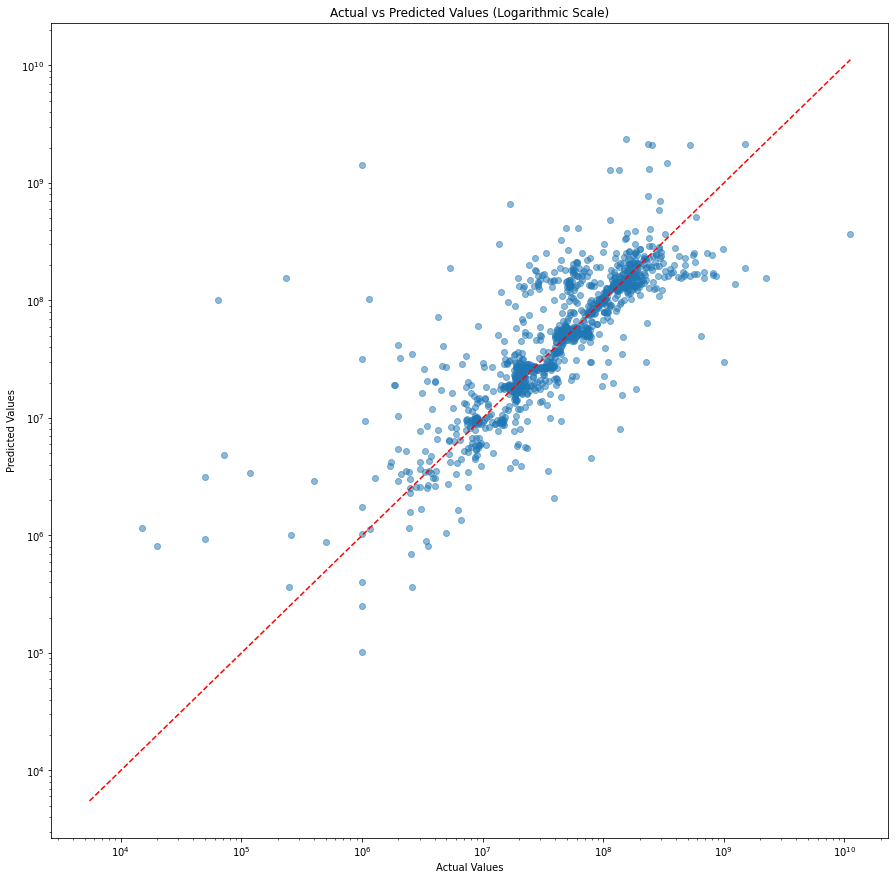

In [107]:
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

predictions.show()

negative_predictions_percentage = (predictions.filter(predictions.prediction < 0).count() / predictions.count()) * 100
print(f"Percentage of negative predictions: {negative_predictions_percentage:.2f}%")

# Initialize the evaluator
evaluator = RegressionEvaluator(labelCol='funding', predictionCol='prediction', metricName='rmse')

# Evaluate the model on the test data
rmse = evaluator.evaluate(predictions)

# Print the RMSE
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Convert predictions to a Pandas DataFrame
predictions_df = predictions.select('prediction', 'funding').toPandas()

# Plot the actual vs predicted values on a logarithmic scale
plt.figure(figsize=(15, 15))
plt.loglog(predictions_df['funding'], predictions_df['prediction'], 'o', alpha=0.5)
plt.plot([predictions_df['funding'].min(), predictions_df['funding'].max()],
         [predictions_df['funding'].min(), predictions_df['funding'].max()],
         color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Logarithmic Scale)')
plt.show()


#### Final Model

In [108]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor

# Define the complete pipeline
final_funding_pipeline= complete_pipeline(unified_full_df)

# Assemble all the features into one column
assembler = VectorAssembler(
    inputCols=[f'{col}_processed' for col in unified_full_df.columns if col not in {"id", "funding"}],
    outputCol="features"
)

# Initialize the GBTRegressor with tuned parameters
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="funding",
    predictionCol="prediction",
    maxIter=200,  # Increase the number of iterations
    stepSize=0.05,
    maxDepth=15,  # Increase the maximum depth of the trees
    subsamplingRate=0.8,  # Use a higher subsampling rate
    maxBins=256  # Increase the number of bins
)

# Create a pipeline to apply the complete pipeline, assembler, and RandomForestRegressor
final_funding_pipeline_model = Pipeline(stages=[final_funding_pipeline, assembler, gbt])

# Fit the model to the training data
final_funding_model = final_funding_pipeline_model.fit(unified_full_df)
final_funding_model.write().overwrite().save("work/models/final_funding_model")

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


#### Imputation

In [112]:
from pyspark.ml import PipelineModel

# Load the supp_funding_model
final_funding_model = PipelineModel.load("work/models/final_funding_model")

# Transform the li_df_2 using the loaded model
imputed_funding_linkedin = final_funding_model.transform(imputed_linkedin_valuations.withColumn("funding", F.lit(0)))

# Show the transformed dataframe
imputed_funding_linkedin = imputed_funding_linkedin.select(*imputed_linkedin_valuations.columns, "prediction").drop('funding').withColumnRenamed("prediction", "funding")
imputed_funding_linkedin.show(5)

+--------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+
|      id|                name|              slogan|         description|        size|          industries|       org_valuation|             funding|
+--------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+
|40754182|       MBC Workshop™|Your Personal Dig...|! Miniature Base ...| 1-10 people| Artists and Writers| 3.844222019721726E7| 3.451184998480046E7|
|28602496|Bartlett Design C...|BARTLETT ARCHITEC...|!!!2015, 2016, 20...| 1-10 people|        Construction| 1.997286283279561E7|1.8975804592210643E7|
|26582223|  $105,000 Challenge|Challenge yoursel...|" Challenge yours...| 1-10 people|Advertising Services|1.8854720854760104E8|1.4067182493963873E8|
| 1961106|Sienna Entertainment|Las Vegas #1 Even...|" Las Vegas #1 VI...|11-50 people|         Hospi

In [115]:
full_imputed_linkedin = imputed_funding_linkedin.union(unified_full_df).filter(F.col("funding") > 0).filter(F.col("org_valuation") > 0)
#full_imputed_linkedin.count()
full_imputed_linkedin.write.mode("overwrite").parquet("work/dataframes/full_imputed_linkedin.parquet")

In [3]:
# Load the fully imputed LinkedIn DataFrame
full_imputed_linkedin = spark.read.parquet("work/dataframes/full_imputed_linkedin.parquet")

# Convert to pandas DataFrame
full_imputed_linkedin_pd = full_imputed_linkedin.toPandas()

# Save as a pickle file
full_imputed_linkedin_pd.to_pickle("work/pickle/full_imputed_linkedin.pkl")